# Estimating statistical information

## This script contains the following:

* Estimation of expected average value on domain $\Omega_2$ using the surrogate-NL with different modes with Monte Carlo sampling

## Problem description
Consider the linear-nonlinear coupled problem with non-linear reaction as in (6.2). Let the output of interest be given by the average value on domain $\Omega_2$, that is

\begin{align}
\label{eq:avg2}
    F(u({x};{\mu})) &= \frac{1}{|\Omega_2|} \int_{\Omega_2} u({x};{\mu}) \ d\Omega_2 \\
         &\approx \frac{1}{N_2} \sum_{i=1}^{N_2} U_{2}^{rb,(i)},
\end{align}

which is approximated by the average value of the elements of the vector ${U}_2^{rb}$. Suppose the quantity of interest is given by the expectation, that is

\begin{align}
\label{eq:qoireaction}
    \mathbb{E}[F] = \int_\mathcal{P} F(u({x};{\mu}))\rho({\mu}) \ d{\mu}. 
\end{align}

Using Monte Carlo Simulation, we aim to approximate $\mathbb{E}[F]$ using the surrogate-NL from
Algorithm 3.4 and compare the results with the FOM

# Import libraries and load functions

In [1]:
%run functions.ipynb

# Offline stage

# Create FOM snapshots and 100 test samples

In [2]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

alreadyrun = 1
if not alreadyrun:
    %run FOM_snapshots.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu_all, mu_lin, mu_nlin,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl]

    with open('offline_vars.pkl', 'wb') as file:
        # create new file
        pickle.dump(variables, file)
        
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu_all, mu_lin, mu_nlin,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl = pickle.load(file)
        
ndofs_U1 = len(S1)
ndofs_U2 = len(S2)
ndofs_UI = len(SI)

# Perform POD analysis

Snapshot energy domain 1: 0.9615473781732398
Snapshot energy domain 2: 0.9716428962619371
Snapshot energy interface: 0.9602596139358491


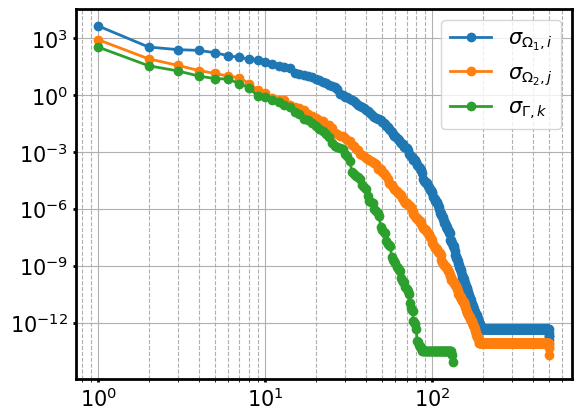

In [3]:
# Choose cutoff values
cutoff1 = 10
cutoffI = 5
cutoff2 = 5

start = time.time()
V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)
end = time.time()

POD_all_time = end - start

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$

In [4]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    learning_rate = 0.1
    
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu_nlin[0:nsamples-ntest]))).float()

    u_2_models34 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.01
            
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34.append(u_2_model)
        
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34, time_u2_34]

    with open('u_2_models34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34.pkl', 'rb') as file:

        # Call load method
        u_2_models34, time_u2_34 = pickle.load(file)

# Train neural network for $\hat{\pi}_\Gamma$

In [7]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu_all[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()

    uI_model4, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    variables = [uI_model4, uI_model4time]


    with open('ugamma4.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4.pkl', 'rb') as file:

        # Call load method
        uI_model4, uI_model4time = pickle.load(file)

# Load Monte Carlo samples

In [5]:
alreadyrun = 1
nsamples = 1000 

if not alreadyrun:
 
    %run MC_snapshots.ipynb
    
    variables = [S2, mu_all, mu_nlin]
    
    with open('MC_variables.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
    
else:
    with open('MC_variables.pkl', 'rb') as file:

        # Call load method
        S2, mu_all, mu_nlin = pickle.load(file)

# Compute the outputs of interest

In [8]:
# Initialize output of interest
OoI_array_FOM = np.zeros((nsamples))
OoI_array_ROM_5 = np.zeros((nsamples))
nmodes =1

for j in range(nsamples):
    OoI_FOM = np.mean(S2[:,j])
    OoI_array_FOM[j] = OoI_FOM
    
    which = j
    mu_test_nlin = mu_nlin[which]
    mu_test_all = mu_all[which]
        
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test_all).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)
    
    u_2_pred_m4 = []

    for i in range(int(cutoff2/nmodes)):
        
        # method 2
        mode2 = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m4,mu_test_nlin))).float()).detach().numpy()
        u_2_pred_m4.append(mode2[0])
        
    u_2_predh_m4 = np.matmul(V_2,u_2_pred_m4)
    
    OoI_ROM = np.mean(u_2_predh_m4)
    
    OoI_array_ROM_5[j] = OoI_ROM
    

# Perform the same task but for $n_\Gamma = n_2 = 2$

Snapshot energy domain 1: 0.9615473781732398
Snapshot energy domain 2: 0.9020922504416775
Snapshot energy interface: 0.8753293751589458


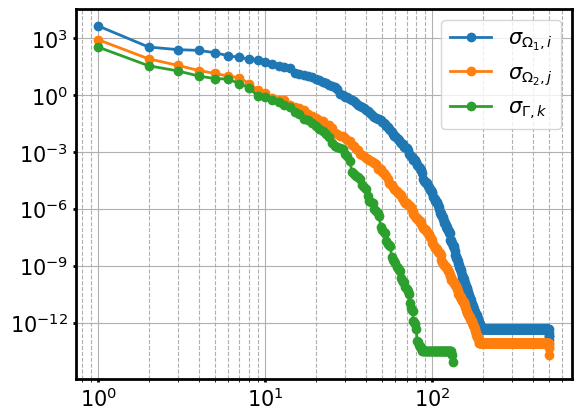

In [9]:
ntest=100
nsamples=500+ntest

with open('offline_vars.pkl', 'rb') as file:

    # Call load method
    S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu_all, mu_lin, mu_nlin,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl = pickle.load(file)

ndofs_U1 = len(S1)
ndofs_U2 = len(S2)
ndofs_UI = len(SI)

cutoff1 = 10
cutoffI = 2
cutoff2 = 2

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

In [10]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    learning_rate = 0.1
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu_nlin[0:nsamples-ntest]))).float()

    u_2_models34small = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.01
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34small.append(u_2_model)
        
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34small, time_u2_34]

    with open('u_2_models34small.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34small.pkl', 'rb') as file:

        # Call load method
        u_2_models34small, time_u2_34 = pickle.load(file)

In [11]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu_all[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()

    uI_model4small, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    variables = [uI_model4small, uI_model4time]
    with open('ugamma4small.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4small.pkl', 'rb') as file:

        # Call load method
        uI_model4small, uI_model4time = pickle.load(file)

In [15]:
alreadyrun = 1
nsamples = 1000
ntest= 0

if not alreadyrun:

    %run MC_snapshots.ipynb
    
    variables = [S2, mu_all, mu_nlin]
    
    with open('MC_variables.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
    
else:
    with open('MC_variables.pkl', 'rb') as file:

        # Call load method
        S2, mu_all, mu_nlin = pickle.load(file)

In [13]:
# Initialize output of interest
OoI_array_ROM_2 = np.zeros((nsamples))

for j in range(nsamples):
    
    which = j
    mu_test_nlin = mu_nlin[which]
    mu_test_all = mu_all[which]
    
    u_I_pred_m4 = uI_model4small(torch.from_numpy(mu_test_all).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)
    
    u_2_pred_m4 = []

    for i in range(int(cutoff2/nmodes)):
        
        # method 2
        mode2 = u_2_models34small[i](torch.from_numpy(np.hstack((u_I_pred_m4,mu_test_nlin))).float()).detach().numpy()
        u_2_pred_m4.append(mode2[0])
        
    u_2_predh_m4 = np.matmul(V_2,u_2_pred_m4)
    OoI_ROM = np.mean(u_2_predh_m4)
    OoI_array_ROM_2[j] = OoI_ROM
    
bins = np.linspace(0.5, 2, 75)

# Convergence of the QoI for both ROM-2 and ROM-5

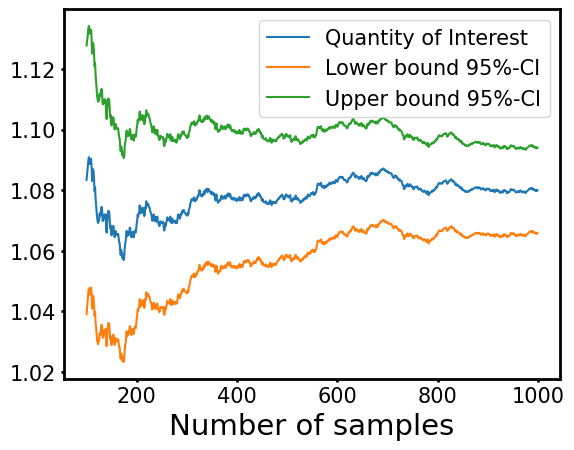

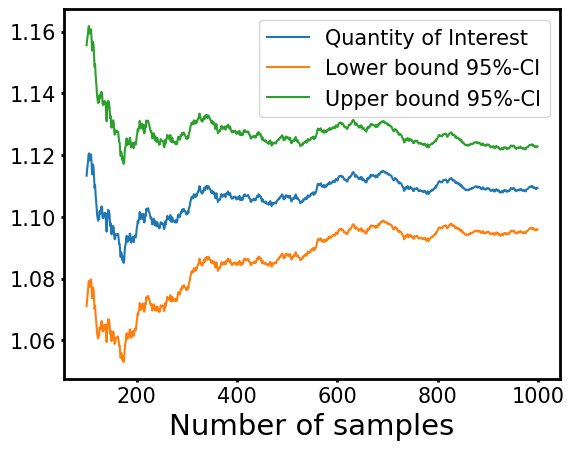

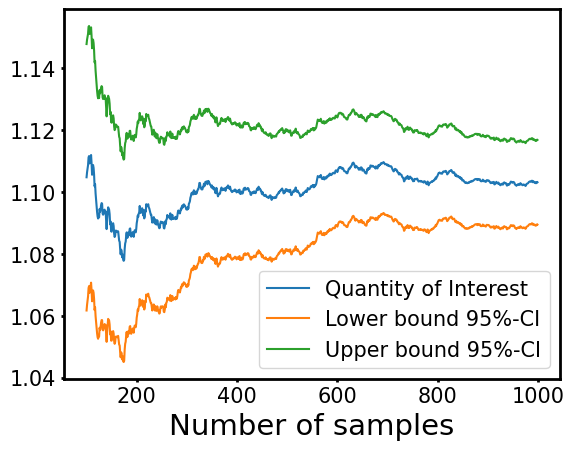

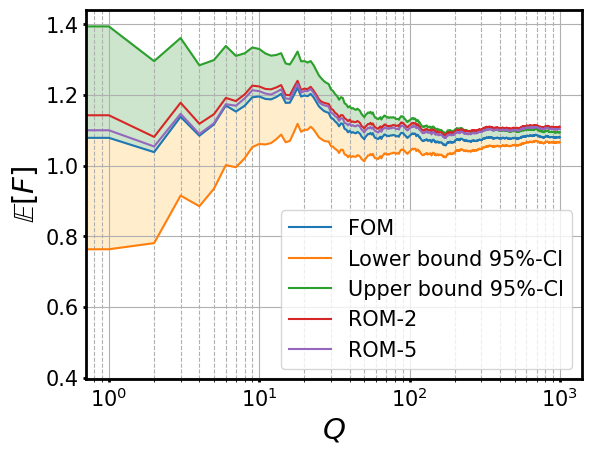

In [18]:
QoI_iter_FOM, QoI_confidence_95_low_iter_FOM, QoI_confidence_95_high_iter_FOM = Monte_Carlo(OoI_array_FOM, nsamples, 1)
QoI_iter_ROM_2, QoI_confidence_95_low_iter, QoI_confidence_95_high_iter = Monte_Carlo(OoI_array_ROM_2, nsamples, 1)
QoI_iter_ROM_5, QoI_confidence_95_low_iter, QoI_confidence_95_high_iter = Monte_Carlo(OoI_array_ROM_5, nsamples, 1)


xaxis = np.arange(0,nsamples)

fig = plt.plot(xaxis,QoI_iter_FOM, label='FOM')
plt.plot(xaxis, QoI_confidence_95_low_iter_FOM, label='Lower bound 95%-CI')
plt.fill_between(xaxis, QoI_iter_FOM, QoI_confidence_95_high_iter_FOM, color= 'green', alpha=0.2)
plt.fill_between(xaxis, QoI_confidence_95_low_iter_FOM, QoI_iter_FOM, color= 'orange', alpha=0.2)


plt.plot(xaxis, QoI_confidence_95_high_iter_FOM, label='Upper bound 95%-CI')
plt.plot(xaxis, QoI_iter_ROM_2, label='ROM-2')
plt.plot(xaxis, QoI_iter_ROM_5, label='ROM-5')

# plt.title('Monte Carlo simulation for $\mathbb{E}[F]$',fontsize=20)
plt.ylabel('$\mathbb{E}[F]$')
plt.xlabel('$Q$')
plt.xscale('log')

plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')
legend = plt.legend()

# plt.savefig('MC25.png', bbox_inches='tight')

plt.show()
        